In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import pickle
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt 
import torch
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import networkx as nx
from tqdm import tqdm
import goatools
from goatools.base import download_go_basic_obo, download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
from goatools.go_enrichment import GOEnrichmentStudy
#from tqdm import tqdm_notebook as tqdm

from dpp.data.network import PPINetwork
from dpp.util import Params, prepare_sns, load_mapping, build_degree_buckets, compute_pvalue
from dpp.data.associations import load_diseases

# os.chdir("/Users/sabrieyuboglu/Documents/School/SNAP/projects/disease-protein-prediction")
os.chdir("/dfs/scratch0/sabri/disease-protein-prediction")
prepare_sns(sns)

In [2]:
diseases = load_diseases("data/associations/disgenet-associations.csv", exclude_splits=["none"])
entrez_to_name = load_mapping("data/protein/symbol_to_entrez.txt", "\t", reverse=True,
                              b_transform=int)

In [3]:
network = PPINetwork("data/networks/bio-pathways-network.txt")

In [4]:
experiment_dir = "experiments/dpp_predict/lci_new"

# LCI

#### Load Weights
Specify a split from which to load weights

In [5]:
split_to_model = {}
for model_split in tqdm(range(10)):
    split_to_model[model_split] = torch.load(os.path.join(experiment_dir, "models", f"model_{model_split}.tar"))

100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


In [6]:
dicts = []
for split in tqdm(range(10)):
    model = split_to_model[split]
    model_stats = {
        "weight": model['linear_layer.weight'].item(), 
        "bias": model['linear_layer.bias'].item(), 
        "mean_z": np.mean(model['E'][0, 0].numpy())
    }
    dicts.append(model_stats)
model_df = pd.DataFrame(dicts, columns=["weight", "bias", "mean_z"])
model_df

100%|██████████| 10/10 [00:00<00:00, 4222.17it/s]


,weight,bias,mean_z
0,17.550322,-0.811245,0.241408
1,17.876070,-0.723686,0.220373
2,16.029150,-1.334732,0.229375
3,16.782249,-0.696910,0.212054
4,18.501001,-1.084714,0.215662
5,15.429231,-1.496836,0.192651
6,16.680628,-0.571429,0.226772
7,12.891609,-1.300265,0.302289
8,17.751625,-0.990272,0.245099
9,16.344975,-0.574154,0.196769


In [7]:
ci_weights = np.mean([model['E'][0, 0].numpy() for model in split_to_model.values()], axis=0)

#### Weight Distribution

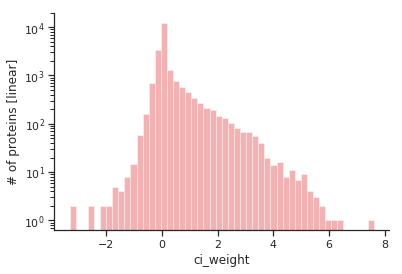

In [84]:
sns.distplot(ci_weights, kde=False)
plt.yscale('log')
plt.xlabel("ci_weight")
plt.ylabel("# of proteins [linear]")
sns.despine()

#### Degree Distribution


In [9]:
degrees = np.array(list(dict(network.nx.degree()).values()))

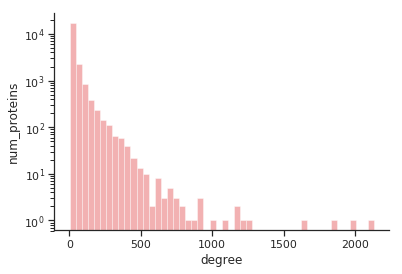

In [85]:
sns.distplot(degrees, kde=False)
plt.yscale('log')
plt.xlabel("degree")
plt.ylabel("num_proteins")
sns.despine()

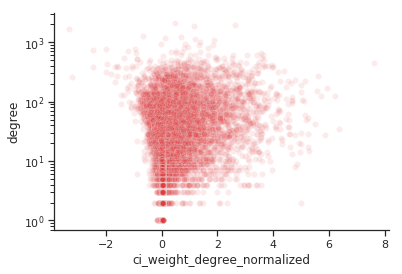

In [86]:
sns.scatterplot(ci_weights, degrees, alpha=0.1)
plt.yscale('log')
plt.ylabel("degree")
plt.xlabel("ci_weight_degree_normalized")
sns.despine()

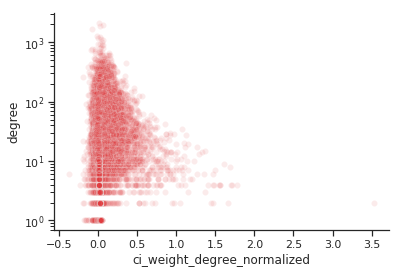

In [91]:
sns.scatterplot(ci_weights / (np.sqrt(degrees)), degrees, alpha=0.1)
plt.yscale('log')
plt.ylabel("degree")
plt.xlabel("ci_weight_degree_normalized")
sns.despine()

In [10]:
degree_df = pd.DataFrame({"degree": degrees,
                          "ci_weight": ci_weights})
mean_degree_df = degree_df.groupby("degree").mean()

Text(0, 0.5, 'mean normalized weight')

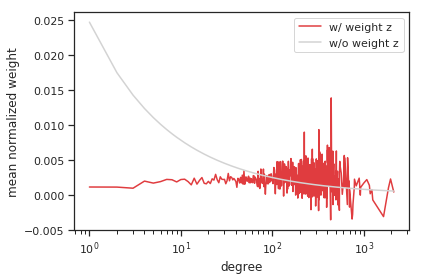

In [14]:
mean_degree_df = degree_df.groupby("degree").mean()
mean_norm_weights = mean_degree_df["ci_weight"] / np.power(mean_degree_df.index, 1/2) #/np.sqrt(mean_degree_df.index) # normalize by degree
mean_norm_weights = mean_norm_weights / mean_norm_weights.sum()
sns.lineplot(x=mean_degree_df.index, y=mean_norm_weights, label='w/ weight z')
y = 1/np.power(mean_degree_df.index, 1/2)
y = y/y.values.sum()
sns.lineplot(x=mean_degree_df.index, y=y, label='w/o weight z')
plt.xscale('log')
plt.yscale('linear')
plt.xlabel('degree')
plt.ylabel('mean normalized weight')

#### Gene Ontology Terms

In [15]:
obodag = GODag("data/go/go-basic.obo")

data/go/go-basic.obo: fmt(1.2) rel(2019-01-19) 47,379 GO Terms


In [16]:
geneid2go = read_ncbi_gene2go("data/go/gene2go.txt", taxids=[9606])

  20,385 items READ: data/go/gene2go.txt


In [17]:
def get_annotations(genes, level=1):
    genes_to_annotations = {gene: set() for gene in genes}
    for gene in genes:
        doids = geneid2go[gene]
        for doid in doids:
            for parent in obodag[doid].get_all_parents():
                if obodag[parent].level == level:
                    genes_to_annotations[gene].add(obodag[parent].name)

    return genes_to_annotations

In [78]:
term_to_proteins = defaultdict(set)
protein_to_terms = defaultdict(set)
for protein in tqdm(network.get_proteins()):
    terms = get_annotations([protein], level=1)[protein]
    protein_to_terms[protein] = terms
    for term in terms:
        term_to_proteins[term].add(protein)




  0%|          | 0/21557 [00:00<?, ?it/s]


  0%|          | 94/21557 [00:00<00:22, 937.27it/s]


  1%|          | 163/21557 [00:00<00:25, 826.02it/s]


  1%|          | 251/21557 [00:00<00:25, 840.61it/s]


  2%|▏         | 330/21557 [00:00<00:26, 813.12it/s]


  2%|▏         | 402/21557 [00:00<00:27, 782.49it/s]


  2%|▏         | 479/21557 [00:00<00:27, 766.61it/s]


  3%|▎         | 615/21557 [00:00<00:24, 870.75it/s]


  3%|▎         | 716/21557 [00:00<00:22, 907.46it/s]


  4%|▍         | 872/21557 [00:00<00:19, 1036.97it/s]


  5%|▍         | 1058/21557 [00:01<00:17, 1194.59it/s]


  6%|▌         | 1191/21557 [00:01<00:16, 1204.13it/s]


  6%|▌         | 1321/21557 [00:01<00:16, 1224.39it/s]


  7%|▋         | 1450/21557 [00:01<00:18, 1109.46it/s]


  7%|▋         | 1568/21557 [00:01<00:20, 994.06it/s] 


  8%|▊         | 1675/21557 [00:01<00:20, 977.71it/s]


  8%|▊         | 1801/21557 [00:01<00:18, 1046.40it/s]


  9%|▉         | 1929/21557 [00:01<00:17, 1097.72it/s]


 10

#### Compute p-values

In [79]:
degree_to_bucket = build_degree_buckets(network, min_len=100)

In [80]:
def get_null_pathways(pathway, quantity=1):
        """
        Given a reference pathway, generate quantity 
        """
        null_pathways = np.zeros((quantity, len(pathway)), dtype=int)
        for i, node in enumerate(pathway):
            degree = network.nx.degree[node]
            null_nodes = np.random.choice(degree_to_bucket[degree], 
                                          size=quantity, 
                                          replace=True)
            null_pathways[:, i] = null_nodes
    
        return null_pathways

In [81]:
# compute pvalues
def functional_pvalue(values):
    """
    """
    term_to_stats = {}
    for term, proteins in tqdm(term_to_proteins.items()):
        nodes = network.get_nodes(term_to_proteins[term])
        term_median = np.median(values[nodes])
        null_proteins = get_null_pathways(nodes, quantity=1000)
        null_medians = np.median(values[null_proteins], axis=1)

        pvalue = compute_pvalue(term_median, null_medians)

        term_to_stats[term] = {
            "pvalue": pvalue,
            "median_weight": term_median, 
            "num_proteins": len(nodes)
        }
    return term_to_stats

In [82]:
term_to_stats = functional_pvalue(ci_weights/np.sqrt(degrees))




  0%|          | 0/51 [00:00<?, ?it/s]


  2%|▏         | 1/51 [00:00<00:30,  1.64it/s]


  4%|▍         | 2/51 [00:00<00:22,  2.18it/s]


  6%|▌         | 3/51 [00:02<00:37,  1.28it/s]


  8%|▊         | 4/51 [00:02<00:30,  1.55it/s]


 10%|▉         | 5/51 [00:03<00:38,  1.18it/s]


 12%|█▏        | 6/51 [00:04<00:29,  1.54it/s]


 14%|█▎        | 7/51 [00:05<00:32,  1.35it/s]


 16%|█▌        | 8/51 [00:05<00:33,  1.30it/s]


 18%|█▊        | 9/51 [00:06<00:28,  1.50it/s]


 20%|█▉        | 10/51 [00:07<00:33,  1.22it/s]


 22%|██▏       | 11/51 [00:08<00:29,  1.35it/s]


 24%|██▎       | 12/51 [00:09<00:35,  1.10it/s]


 25%|██▌       | 13/51 [00:09<00:29,  1.30it/s]


 27%|██▋       | 14/51 [00:10<00:27,  1.33it/s]


 29%|██▉       | 15/51 [00:10<00:21,  1.70it/s]


 31%|███▏      | 16/51 [00:11<00:20,  1.74it/s]


 33%|███▎      | 17/51 [00:11<00:16,  2.05it/s]


 35%|███▌      | 18/51 [00:12<00:17,  1.92it/s]


 37%|███▋      | 19/51 [00:12<00:17,  1.81it/s]


 39%|███▉      

In [83]:
norm_term_df = pd.DataFrame(term_to_stats.values(), index=term_to_stats.keys())
norm_term_df.to_csv("experiments/lci_analysis/terms.csv")
norm_term_df

,median_weight,num_proteins,pvalue
localization,0.017672,4361,0.000
membrane-enclosed lumen,0.026441,1184,0.000
cell part,0.014150,14714,0.165
extracellular region part,0.022696,3159,0.000
cellular process,0.015438,12622,0.000
immune system process,0.025622,1962,0.000
organelle,0.014459,10244,0.056
organelle part,0.014355,9029,0.110
response to stimulus,0.022697,4664,0.000
biological regulation,0.015923,10640,0.000


In [84]:
term_df = pd.DataFrame(term_to_stats.values(), index=term_to_stats.keys())
term_df.to_csv("experiments/lci_analysis/level_1.csv")
term_df

,median_weight,num_proteins,pvalue
localization,0.017672,4361,0.000
membrane-enclosed lumen,0.026441,1184,0.000
cell part,0.014150,14714,0.165
extracellular region part,0.022696,3159,0.000
cellular process,0.015438,12622,0.000
immune system process,0.025622,1962,0.000
organelle,0.014459,10244,0.056
organelle part,0.014355,9029,0.110
response to stimulus,0.022697,4664,0.000
biological regulation,0.015923,10640,0.000


protein activation cascade: 0.893173336982727: 27
extracellular matrix binding: 0.621437668800354: 30
hormone binding: 0.5100924372673035: 91
structural constituent of synapse: 0.7167855501174927: 15
response to stimulus involved in regulation of muscle adaptation: 0.8087355494499207: 15
morphogenesis of a branching structure: 0.5014640688896179: 141
tissue remodeling: 0.8911867737770081: 59
pigment metabolic process: 0.5799788236618042: 60
response to activity: 0.6827540397644043: 24
ovulation cycle process: 0.5555307269096375: 39
muscle cell proliferation: 0.6043993234634399: 17
circadian rhythm: 0.5349343419075012: 71
rhythmic behavior: 0.8451180458068848: 19
killing of cells of other organism: 0.6136441826820374: 12
exogenous protein binding: 0.5473726391792297: 73
tolerance induction: 1.376171350479126: 11
exploration behavior: 0.8437885642051697: 12
reproductive behavior: 0.6426804065704346: 29
organ growth: 0.6042209267616272: 20
aging: 0.5136938095092773: 82


No handles with labels found to put in legend.


mesenchymal cell proliferation: 0.9102386832237244: 12
developmental induction: 0.5733556151390076: 21
glycoprotein complex: 1.303619623184204: 17
chaperone complex: 1.3357160091400146: 11
amyloid-beta clearance: 0.8825898766517639: 13
DNA repair complex: 1.062806248664856: 34
ovulation cycle: 0.7445744872093201: 14


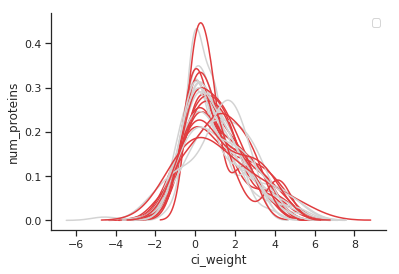

In [43]:
# plot
terms = term_to_proteins.keys() #['transcription regulator activity']
for term in terms:
    nodes = network.get_nodes(term_to_proteins[term])
    #sns.scatterplot(ci_weights[nodes], degrees[nodes], alpha=0.1, label=term)
    median = np.median(ci_weights[nodes])
    if median > 0.5 and len(nodes) > 10:
        print(f"{term}: {median}: {len(nodes)}")
        sns.distplot(ci_weights[nodes], hist=False)

plt.yscale('linear')
plt.ylabel("num_proteins")
plt.xlabel("ci_weight")
plt.legend()
sns.despine()

# Common Interactors

In [23]:
def compute_common_interactors(diseases, network, null=False): 
    """
    """
    adj = network.adj_matrix
    ci_pairs = [set() for i in range(len(network))]
    ci_diseases = [set() for i in range(len(network))]
    for disease in tqdm(diseases.values()):
        proteins = disease.to_node_array(network)
        if null:
            proteins = np.random.choice(adj.shape[0], len(proteins), replace=False)

        for a, protein_a in enumerate(proteins):
            for b, protein_b in enumerate(proteins):
                if a < b:
                    break 
                neighbors_a = adj[protein_a, :]
                neighbors_b = adj[protein_b, :]
                cis = np.where(np.multiply(neighbors_a, neighbors_b) == 1)[0]
                for ci in cis:
                    ci_pairs[ci].add((protein_a, protein_b))
                    ci_diseases[ci].add(disease.id)
    return ci_pairs, ci_diseases

In [24]:
null_pairs = []
null_diseases = []
for i in range(30): 
    ci_pairs, ci_diseases  = compute_common_interactors(diseases, network, null=True)
    null_pairs.append(ci_pairs)
    null_diseases.append(ci_diseases)

100%|██████████| 2297/2297 [04:01<00:00,  9.53it/s]  


In [25]:
null_n_pairs = [np.array(map(len, pairs)) for pairs in null_pairs]

In [ ]:
with open("experiments/dpp_evaluate/lci/null_pairs.pkl",'wb') as f:
    pickle.dump(null_pairs, f)

In [ ]:
np.stack(null_n_pairs, axis=1).shape

In [ ]:
mean_null_n_pairs = np.mean(np.stack(null_n_pairs, axis=1), axis=1)

In [ ]:
degree_vec = np.array([network.nx.degree(node) for node in range(len(network))])